In [2]:
!pip -q install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
!pip -q install pandas numpy matplotlib scikit-learn scipy

import os, math, itertools, json, warnings
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)


In [3]:
DATA_DIR = "/content"

FILENAMES = {
    "BTC":    "CBBTCUSD.csv",
    "ETH":    "CBETHUSD.csv",
    "LTC":    "CBLTCUSD.csv",
    "BCH":    "CBBCHUSD.csv",
    "FIAT":   "DTWEXBGS.csv",
    "EQUITY": "MSF_1996_2023 (1).csv",
    "GOLD":   "NASDAQQGLDI.csv",
    "ENERGY": "VDE.csv",
}


MARKET_SET = ["FIAT"]

# Hyperparameters & splits
LOOKBACK_GRID = [12, 24, 36]
HIDDEN_UNITS_GRID = [4, 8, 16]
LR_GRID = [1e-3, 1e-2, 1e-1]

import torch
import torch.nn as nn
ACTIVATIONS = {
    "linear": nn.Identity(),
    "sigmoid": nn.Sigmoid(),
    "tanh": nn.Tanh(),
    "relu": nn.ReLU()
}

BATCH_SIZE = 256
EPOCHS = 150
PATIENCE = 15
SEED = 42

# Date splits (monthly)
TRAIN_START, TRAIN_END = "2015-01", "2019-12"
VAL_START,   VAL_END   = "2020-01", "2021-12"
TEST_START,  TEST_END  = "2022-01", "2023-12"

import numpy as np
np.random.seed(SEED)
torch.manual_seed(SEED)


In [4]:
import os

print("DATA_DIR =", DATA_DIR)
try:
    print("Files in DATA_DIR:", sorted(os.listdir(DATA_DIR))[:60])
except FileNotFoundError:
    raise FileNotFoundError(f"DATA_DIR not found: {DATA_DIR} — mount Drive or fix the path.")

for k, v in FILENAMES.items():
    p = os.path.join(DATA_DIR, v)
    print(f"{k:7s} -> {p}  {'OK' if os.path.exists(p) else 'MISSING'}")


DATA_DIR = /content
Files in DATA_DIR: ['.config', '.ipynb_checkpoints', 'CBBCHUSD.csv', 'CBBTCUSD.csv', 'CBETHUSD.csv', 'CBLTCUSD.csv', 'DTWEXBGS.csv', 'F-F_Research_Data_5_Factors_2x3_daily.csv', 'MSF_1996_2023 (1).csv', 'NASDAQQGLDI.csv', 'VDE.csv', 'sample_data']
BTC     -> /content/CBBTCUSD.csv  OK
ETH     -> /content/CBETHUSD.csv  OK
LTC     -> /content/CBLTCUSD.csv  OK
BCH     -> /content/CBBCHUSD.csv  OK
FIAT    -> /content/DTWEXBGS.csv  OK
EQUITY  -> /content/MSF_1996_2023 (1).csv  OK
GOLD    -> /content/NASDAQQGLDI.csv  OK
ENERGY  -> /content/VDE.csv  OK


In [5]:
import math, warnings
from typing import Dict, List, Tuple
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)

def clip_by_dates(df: pd.DataFrame, start_ym: str, end_ym: str) -> pd.DataFrame:
    mask = (df["date"] >= pd.to_datetime(f"{start_ym}-01")) & \
           (df["date"] <= pd.to_datetime(f"{end_ym}-28") + pd.offsets.MonthEnd(0))
    return df.loc[mask].copy().reset_index(drop=True)


In [6]:
import re

def _to_numeric(series: pd.Series, make_abs=False):
    s = series.astype(str).str.replace(",", "", regex=False).str.strip()
    s = s.replace({"B": np.nan, "C": np.nan, "": np.nan, ".": np.nan})
    out = pd.to_numeric(s, errors="coerce")
    if make_abs:
        out = out.abs()
    return out

def _read_csv_guess(path: str) -> pd.DataFrame:
    """Robust reader: find a date col + either returns or prices."""
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    low = {c.lower(): c for c in df.columns}

    # date-ish column
    date_col = None
    for key in ["date","caldt","dt","yyyymm","time"]:
        if key in low:
            date_col = low[key]; break
    if date_col is None:
        date_col = df.columns[0]

    # prefer returns if present
    ret_col = None
    for c in df.columns:
        if c.lower() in ("vwretd","ret","return","returns"):
            ret_col = c; break

    if ret_col:
        out = df[[date_col, ret_col]].copy()
        out.columns = ["date","ret"]
        out["ret"] = _to_numeric(out["ret"], make_abs=False)
    else:
        price_col = None
        for c in df.columns:
            if c.lower() in ("prc","close","adj close","adj_close","price","px","index","value"):
                price_col = c; break
        if price_col is None:
            price_col = df.columns[-1]
        out = df[[date_col, price_col]].copy()
        out.columns = ["date","price"]
        out["price"] = _to_numeric(out["price"], make_abs=True)


    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    out = out.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
    return out

def daily_to_monthly_last(df: pd.DataFrame) -> pd.DataFrame:
    o = df.copy()
    o["ym"] = o["date"].dt.to_period("M").dt.to_timestamp("M")
    if "price" in o.columns:
        out = o.groupby("ym", as_index=False).agg({"price":"last"})
    else:
        tmp = o.dropna(subset=["ret"]).copy()
        tmp["ret"] = _to_numeric(tmp["ret"])
        tmp = tmp.dropna(subset=["ret"])
        tmp["px"] = 100.0 * (1.0 + tmp["ret"]).cumprod()
        out = tmp.groupby("ym", as_index=False).agg({"px":"last"}).rename(columns={"px":"price"})
    out = out.rename(columns={"ym":"date"})
    return out

def to_monthly_returns(df_price_monthly: pd.DataFrame) -> pd.DataFrame:
    df = df_price_monthly.copy()
    df["price"] = _to_numeric(df["price"], make_abs=True)
    df = df.dropna(subset=["price"]).sort_values("date").reset_index(drop=True)
    df["ret"] = df["price"].pct_change()
    return df.dropna(subset=["ret"]).reset_index(drop=True)


In [7]:
def _parse_crsp_like_dates(s: pd.Series):
    raw = s.astype(str).str.strip()
    digits = raw.str.replace(r"[^0-9]", "", regex=True)
    out = pd.Series(pd.NaT, index=s.index, dtype="datetime64[ns]")

    m6 = digits.str.len().eq(6)   # YYYYMM
    if m6.any():
        out.loc[m6] = pd.to_datetime(digits[m6], format="%Y%m", errors="coerce") + pd.offsets.MonthEnd(0)

    m8 = digits.str.len().eq(8)   # YYYYMMDD
    if m8.any():
        out.loc[m8] = pd.to_datetime(digits[m8], format="%Y%m%d", errors="coerce")

    rem = ~(m6 | m8)
    if rem.any():
        out.loc[rem] = pd.to_datetime(raw[rem], errors="coerce")

    return out

_old_read = _read_csv_guess
def _read_csv_guess(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    low = {c.lower(): c for c in df.columns}

    # date
    date_col = None
    for key in ["date","caldt","dt","yyyymm","time"]:
        if key in low: date_col = low[key]; break
    if date_col is None:
        date_col = df.columns[0]

    # returns or price
    ret_col = None
    for c in df.columns:
        if c.lower() in ("vwretd","ret","return","returns"):
            ret_col = c; break

    if ret_col:
        out = df[[date_col, ret_col]].copy()
        out.columns = ["date","ret"]
        out["ret"] = _to_numeric(out["ret"], make_abs=False)
    else:
        price_col = None
        for c in df.columns:
            if c.lower() in ("prc","close","adj close","adj_close","price","px","index","value"):
                price_col = c; break
        if price_col is None:
            price_col = df.columns[-1]
        out = df[[date_col, price_col]].copy()
        out.columns = ["date","price"]
        out["price"] = _to_numeric(out["price"], make_abs=True)

    out["date"] = _parse_crsp_like_dates(out["date"])
    out = out.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
    return out


In [8]:
import os

src = os.path.join(DATA_DIR, "MSF_1996_2023 (1).csv")  # your uploaded CRSP MSF file
msf = pd.read_csv(src)
msf.columns = [c.strip() for c in msf.columns]

# Identify columns (edit if your export uses different names)
date_col = next((c for c in msf.columns if c.lower() in ("date","yyyymm","caldt")), msf.columns[0])
ret_col  = next((c for c in msf.columns if c.lower() in ("ret","vwretd","return","returns")), None)
prc_col  = next((c for c in msf.columns if c.lower() in ("prc","price","close","adj close","adj_close")), None)
shr_col  = next((c for c in msf.columns if c.lower() in ("shrout","shares","sharesout","shroutn")), None)

if ret_col is None or prc_col is None or shr_col is None:
    raise ValueError(f"CRSP MSF needs RET/PRC/SHROUT-like cols. Found: {ret_col=} {prc_col=} {shr_col=}")

def _parse_msf_date(s: pd.Series):
    raw = s.astype(str).str.strip()
    dgt = raw.str.replace(r"[^0-9]", "", regex=True)
    out = pd.Series(pd.NaT, index=s.index, dtype="datetime64[ns]")
    m6  = dgt.str.len().eq(6)
    if m6.any(): out.loc[m6] = pd.to_datetime(dgt[m6], format="%Y%m", errors="coerce") + pd.offsets.MonthEnd(0)
    m8  = dgt.str.len().eq(8)
    if m8.any(): out.loc[m8] = pd.to_datetime(dgt[m8], format="%Y%m%d", errors="coerce")
    rem = ~(m6 | m8)
    if rem.any(): out.loc[rem] = pd.to_datetime(raw[rem], errors="coerce")
    return out

msf = msf.rename(columns={date_col: "date"})
msf["date"]   = _parse_msf_date(msf["date"])
msf["RET"]    = _to_numeric(msf[ret_col], make_abs=False)
msf["PRC"]    = _to_numeric(msf[prc_col], make_abs=True)   # CRSP PRC can be negative; take abs
msf["SHROUT"] = _to_numeric(msf[shr_col], make_abs=True)

msf = msf.dropna(subset=["date","RET","PRC","SHROUT"]).reset_index(drop=True)
msf["MCAP"] = msf["PRC"] * msf["SHROUT"]

# Value-weighted market return per month
vw = (msf.groupby("date")
          .apply(lambda g: float(np.sum(g["MCAP"] * g["RET"]) / np.sum(g["MCAP"])))
          .reset_index(name="ret"))

# Focus on crypto era (optional)
vw = vw.loc[vw["date"] >= pd.to_datetime("2015-01-31")].reset_index(drop=True)

# Save and update EQUITY mapping to this derived file
out_csv = os.path.join(DATA_DIR, "CRSP_VW_Market.csv")
vw.to_csv(out_csv, index=False)
FILENAMES["EQUITY"] = "CRSP_VW_Market.csv"

print("Saved VW market to:", out_csv,
      " range:", vw['date'].min().date(), "→", vw['date'].max().date(), " n=", len(vw))


Saved VW market to: /content/CRSP_VW_Market.csv  range: 2015-02-27 → 2023-12-29  n= 107


In [9]:
# Uses: _read_csv_guess, daily_to_monthly_last, to_monthly_returns, DATA_DIR, FILENAMES, MARKET_SET

def _safe_load_series(label: str, fname: str):
    fp = os.path.join(DATA_DIR, fname)
    if not os.path.exists(fp):
        print(f"[WARN] {label}: file not found at {fp}. Skipping {label}.")
        return None
    try:
        df = _read_csv_guess(fp)
        df = daily_to_monthly_last(df)
        df = to_monthly_returns(df)
        if len(df) == 0:
            print(f"[WARN] {label}: parsed but empty after monthly conversion. Skipping.")
            return None
        return df
    except Exception as e:
        print(f"[WARN] {label}: failed to parse {fp}: {e}. Skipping {label}.")
        return None

def align_monthly_required(ret_d: Dict[str, pd.DataFrame], required_keys: List[str]) -> pd.DataFrame:
    out = None
    for k in required_keys:
        d = ret_d[k][["date", "ret"]].copy().rename(columns={"ret": k})
        out = d if out is None else pd.merge(out, d, on="date", how="inner")
    out = out.sort_values("date").reset_index(drop=True)
    return out

def add_optional_series(base_df: pd.DataFrame, ret_d: Dict[str, pd.DataFrame], optional_keys: List[str]) -> pd.DataFrame:
    out = base_df.copy()
    for k in optional_keys:
        d = ret_d[k][["date", "ret"]].copy().rename(columns={"ret": k})
        out = out.merge(d, on="date", how="left")
    return out

# ---------- Load all ----------
series_monthly_ret: Dict[str, pd.DataFrame] = {}

# Cryptos
for sym in ["BTC","ETH","LTC","BCH"]:
    df = _safe_load_series(sym, FILENAMES[sym])
    if df is not None:
        series_monthly_ret[sym] = df

# Markets
for m in ["FIAT","EQUITY","GOLD","ENERGY"]:
    df = _safe_load_series(m, FILENAMES.get(m, ""))
    if df is not None:
        series_monthly_ret[m] = df

if not series_monthly_ret:
    raise RuntimeError("No series loaded. Check DATA_DIR and FILENAMES in Cell 2/2.1.")

cryptos_avail = [c for c in ["BTC","ETH","LTC","BCH"] if c in series_monthly_ret]
if not cryptos_avail:
    raise RuntimeError("No crypto series loaded.")

markets_loaded = [k for k in ["FIAT","EQUITY","GOLD","ENERGY"] if k in series_monthly_ret]
markets_needed = [m for m in MARKET_SET if m in series_monthly_ret]

if not markets_needed:
    if markets_loaded:
        print(f"[WARN] None of {MARKET_SET} loaded. Falling back to: {markets_loaded[0]}")
        markets_needed = [markets_loaded[0]]
    else:
        raise RuntimeError("No market series loaded.")

required_keys = cryptos_avail + markets_needed
optional_keys = [k for k in series_monthly_ret.keys() if k not in required_keys]

monthly_core = align_monthly_required(series_monthly_ret, required_keys)
monthly = add_optional_series(monthly_core, series_monthly_ret, optional_keys)

# ---------- Diagnostics ----------
print("=== SERIES RANGES ===")
for k in required_keys + optional_keys:
    d = series_monthly_ret[k]
    start = d["date"].min().date() if len(d) else None
    end   = d["date"].max().date() if len(d) else None
    n     = len(d)
    print(f"{k:7s}: start={start} end={end} n={n}")

if len(monthly) == 0:
    print("\n[DIAG] No overlapping months across REQUIRED series:", required_keys)
    print("Adjust MARKET_SET, check file date ranges, or reduce lookback.")
else:
    print(f"\nAligned (required) rows: {len(monthly_core)}")
    print("Columns:", list(monthly.columns))

from IPython.display import display
display(monthly.head(10))
print("Monthly shape:", monthly.shape)
print("MARKET_SET (effective) =", markets_needed)


=== SERIES RANGES ===
BTC    : start=2015-01-31 end=2025-10-31 n=130
ETH    : start=2016-06-30 end=2025-10-31 n=113
LTC    : start=2016-09-30 end=2025-10-31 n=110
BCH    : start=2018-01-31 end=2025-10-31 n=94
FIAT   : start=2015-02-28 end=2025-10-31 n=129
EQUITY : start=2015-03-31 end=2023-12-31 n=106
GOLD   : start=2015-02-28 end=2025-10-31 n=129
ENERGY : start=2005-03-31 end=2025-10-31 n=248

Aligned (required) rows: 94
Columns: ['date', 'BTC', 'ETH', 'LTC', 'BCH', 'FIAT', 'EQUITY', 'GOLD', 'ENERGY']


,date,BTC,ETH,LTC,BCH,FIAT,EQUITY,GOLD,ENERGY
0,2018-01-31,-0.271450,0.490698,-0.287318,-0.377777,-0.030059,0.062517,0.023980,0.031597
1,2018-02-28,0.020523,-0.230785,0.248425,-0.187949,0.015178,-0.030923,-0.018814,-0.107426
2,2018-03-31,-0.327805,-0.535830,-0.424698,-0.428893,-0.008412,-0.018845,0.006102,0.020354
3,2018-04-30,0.334173,0.697699,0.275628,0.977262,0.017281,0.008780,-0.010329,0.096906
4,2018-05-31,-0.190270,-0.138412,-0.202049,-0.263230,0.024259,0.033177,-0.015918,0.035874
5,2018-06-30,-0.147202,-0.214538,-0.315563,-0.248090,0.011343,0.009780,-0.035705,0.007341
6,2018-07-31,0.210566,-0.046196,-0.026293,0.037599,-0.004667,0.037438,-0.025127,0.010914
7,2018-08-31,-0.092175,-0.347889,-0.212348,-0.301064,0.013708,0.041999,-0.019857,-0.029578
8,2018-09-30,-0.058448,-0.176172,-0.017383,-0.023591,-0.004094,0.005400,-0.008599,0.026366
9,2018-10-31,-0.045544,-0.152064,-0.189681,-0.202163,0.023897,-0.067104,0.019823,-0.121107


Monthly shape: (94, 9)
MARKET_SET (effective) = ['FIAT']


In [10]:
def make_panel(monthly: pd.DataFrame, market_cols: List[str], w: int) -> pd.DataFrame:
    """
    Returns a panel with columns:
    ['date','crypto','target_next','asset_ret_next', 'feat_*']
    where feats include rolling windows of crypto & market returns (t-w+1 ... t).
    """
    cryptos = ["BTC","ETH","LTC","BCH"]
    need_cols = ["date"] + cryptos + market_cols
    df = monthly[need_cols].copy().dropna().reset_index(drop=True)

    # If multiple markets: make an equal-weight "asset" return
    if len(market_cols) == 1:
        df["asset_ret"] = df[market_cols[0]]
    else:
        df["asset_ret"] = df[market_cols].mean(axis=1)

    rows = []
    for c in cryptos:
        cdf = df[["date", c, "asset_ret"]].copy()
        # Build rolling windows ending at t (not including t+1)
        for i in range(w, len(cdf)-1):  # ensure i+1 exists for target/asset_next
            end_idx = i
            start_idx = i - w
            window = cdf.iloc[start_idx:end_idx]  # t-w ... t-1
            d_t = cdf.iloc[end_idx]["date"]
            target_next = cdf.iloc[end_idx+1][c]               # r_{t+1} for crypto
            asset_next = cdf.iloc[end_idx+1]["asset_ret"]      # r_{t+1} for asset

            feats = {}
            # crypto lag returns
            for k, r in enumerate(window[c].values):
                feats[f"c_lag_{w-k}"] = r
            # market lag returns
            for k, r in enumerate(window["asset_ret"].values):
                feats[f"a_lag_{w-k}"] = r

            rows.append({
                "date": d_t,
                "crypto": c,
                "target_next": target_next,
                "asset_ret_next": asset_next,
                **feats
            })

    out = pd.DataFrame(rows)
    out = out.dropna().reset_index(drop=True)
    return out


# Quick smoke test for one w before the full grid
test_panel = make_panel(monthly, MARKET_SET, w=12)
display(test_panel.head())
print("Panel shape (w=12):", test_panel.shape)


,date,crypto,target_next,asset_ret_next,c_lag_12,c_lag_11,c_lag_10,c_lag_9,c_lag_8,c_lag_7,c_lag_6,c_lag_5,c_lag_4,c_lag_3,c_lag_2,c_lag_1,a_lag_12,a_lag_11,a_lag_10,a_lag_9,a_lag_8,a_lag_7,a_lag_6,a_lag_5,a_lag_4,a_lag_3,a_lag_2,a_lag_1
0,2019-01-31,BTC,0.111576,0.005720,-0.271450,0.020523,-0.327805,0.334173,-0.190270,-0.147202,0.210566,-0.092175,-0.058448,-0.045544,-0.369307,-0.071464,-0.030059,0.015178,-0.008412,0.017281,0.024259,0.011343,-0.004667,0.013708,-0.004094,0.023897,-0.000984,-0.007262
1,2019-02-28,BTC,0.079863,0.008225,0.020523,-0.327805,0.334173,-0.190270,-0.147202,0.210566,-0.092175,-0.058448,-0.045544,-0.369307,-0.071464,-0.075940,0.015178,-0.008412,0.017281,0.024259,0.011343,-0.004667,0.013708,-0.004094,0.023897,-0.000984,-0.007262,-0.017471
2,2019-03-31,BTC,0.287107,0.001654,-0.327805,0.334173,-0.190270,-0.147202,0.210566,-0.092175,-0.058448,-0.045544,-0.369307,-0.071464,-0.075940,0.111576,-0.008412,0.017281,0.024259,0.011343,-0.004667,0.013708,-0.004094,0.023897,-0.000984,-0.007262,-0.017471,0.005720
3,2019-04-30,BTC,0.622213,0.012149,0.334173,-0.190270,-0.147202,0.210566,-0.092175,-0.058448,-0.045544,-0.369307,-0.071464,-0.075940,0.111576,0.079863,0.017281,0.024259,0.011343,-0.004667,0.013708,-0.004094,0.023897,-0.000984,-0.007262,-0.017471,0.005720,0.008225
4,2019-05-31,BTC,0.260645,-0.018372,-0.190270,-0.147202,0.210566,-0.092175,-0.058448,-0.045544,-0.369307,-0.071464,-0.075940,0.111576,0.079863,0.287107,0.024259,0.011343,-0.004667,0.013708,-0.004094,0.023897,-0.000984,-0.007262,-0.017471,0.005720,0.008225,0.001654


Panel shape (w=12): (324, 28)


In [11]:
def split_by_date(panel: pd.DataFrame,
                  train=(TRAIN_START, TRAIN_END),
                  val=(VAL_START, VAL_END),
                  test=(TEST_START, TEST_END)) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    def _clip(df, a, b):
        mask = (df["date"] >= pd.to_datetime(f"{a}-01")) & (df["date"] <= pd.to_datetime(f"{b}-28") + pd.offsets.MonthEnd(0))
        return df.loc[mask].copy().reset_index(drop=True)
    return _clip(panel, *train), _clip(panel, *val), _clip(panel, *test)


def build_xy(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray, List[str]]:
    feat_cols = [c for c in df.columns if c.startswith("c_lag_") or c.startswith("a_lag_")]
    X = df[feat_cols].to_numpy(dtype=np.float32)
    y = df["target_next"].to_numpy(dtype=np.float32).reshape(-1, 1)
    a = df["asset_ret_next"].to_numpy(dtype=np.float32).reshape(-1, 1)  # needed inside loss
    return X, y, a, feat_cols


In [12]:
class PanelDataset(Dataset):
    def __init__(self, X, y, a):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
        self.a = torch.from_numpy(a)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx): return self.X[idx], self.y[idx], self.a[idx]


class MLPBeta(nn.Module):
    def __init__(self, in_dim: int, hidden: int, activation: nn.Module):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            activation,
            nn.Linear(hidden, 1)  # linear output: beta_hat
        )
    def forward(self, x):
        return self.net(x)


def beta_rmse_loss(beta_hat, y_true, a_next):
    """
    y_true ~ r_crypto_{t+1}
    prediction = beta_hat * r_asset_{t+1}
    """
    pred = beta_hat * a_next
    return torch.sqrt(torch.mean((y_true - pred)**2))


def train_model(X_tr, y_tr, a_tr, X_va, y_va, a_va, hidden:int, lr:float, activation: nn.Module,
                epochs:int=EPOCHS, batch_size:int=BATCH_SIZE, patience:int=PATIENCE, seed:int=SEED):

    torch.manual_seed(seed)
    in_dim = X_tr.shape[1]
    model = MLPBeta(in_dim, hidden, activation)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_state, best_val = None, float("inf")
    tr_hist, va_hist = [], []
    wait = 0

    dl_tr = DataLoader(PanelDataset(X_tr, y_tr, a_tr), batch_size=batch_size, shuffle=True)
    dl_va = DataLoader(PanelDataset(X_va, y_va, a_va), batch_size=batch_size, shuffle=False)

    for ep in range(epochs):
        model.train()
        ep_losses = []
        for xb, yb, ab in dl_tr:
            opt.zero_grad()
            bh = model(xb)
            loss = beta_rmse_loss(bh, yb, ab)
            loss.backward()
            opt.step()
            ep_losses.append(loss.item())
        tr_loss = float(np.mean(ep_losses))

        model.eval()
        with torch.no_grad():
            va_losses = []
            for xb, yb, ab in dl_va:
                bh = model(xb)
                va_losses.append(beta_rmse_loss(bh, yb, ab).item())
            va_loss = float(np.mean(va_losses))

        tr_hist.append(tr_loss)
        va_hist.append(va_loss)

        if va_loss < best_val - 1e-7:
            best_val = va_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    # Load best
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, {"train_loss": tr_hist, "val_loss": va_hist, "best_val": best_val}


In [13]:
def tune_and_train(monthly, market_set, lookbacks, hidden_grid, lr_grid, activations):
    results = []
    for w in lookbacks:
        panel = make_panel(monthly, market_set, w=w)
        tr, va, te = split_by_date(panel)
        if len(tr)==0 or len(va)==0:
            print(f"[w={w}] Not enough data for splits. Skipping.")
            continue
        X_tr, y_tr, a_tr, feat_cols = build_xy(tr)
        X_va, y_va, a_va, _ = build_xy(va)

        for h, lr, (aname, act) in itertools.product(hidden_grid, lr_grid, activations.items()):
            model, hist = train_model(X_tr, y_tr, a_tr, X_va, y_va, a_va,
                                      hidden=h, lr=lr, activation=act)
            results.append({
                "w": w, "hidden": h, "lr": lr, "activation": aname,
                "val_rmse": hist["best_val"], "hist": hist, "model": model, "feat_cols": feat_cols
            })
            print(f"[w={w}, h={h}, lr={lr}, act={aname}] val RMSE={hist['best_val']:.6f}")

    # Rank by best validation RMSE
    results = sorted(results, key=lambda d: d["val_rmse"])
    return results

tuning_results = tune_and_train(monthly, MARKET_SET, LOOKBACK_GRID, HIDDEN_UNITS_GRID, LR_GRID, ACTIVATIONS)
print("\nTop 5 configs:")
for r in tuning_results[:5]:
    print({k:r[k] for k in ["w","hidden","lr","activation","val_rmse"]})


[w=12, h=4, lr=0.001, act=linear] val RMSE=0.276837
[w=12, h=4, lr=0.001, act=sigmoid] val RMSE=0.274697
[w=12, h=4, lr=0.001, act=tanh] val RMSE=0.276820
[w=12, h=4, lr=0.001, act=relu] val RMSE=0.276119
[w=12, h=4, lr=0.01, act=linear] val RMSE=0.276995
[w=12, h=4, lr=0.01, act=sigmoid] val RMSE=0.274888
[w=12, h=4, lr=0.01, act=tanh] val RMSE=0.276970
[w=12, h=4, lr=0.01, act=relu] val RMSE=0.276199
[w=12, h=4, lr=0.1, act=linear] val RMSE=0.278600
[w=12, h=4, lr=0.1, act=sigmoid] val RMSE=0.276796
[w=12, h=4, lr=0.1, act=tanh] val RMSE=0.278470
[w=12, h=4, lr=0.1, act=relu] val RMSE=0.269797
[w=12, h=8, lr=0.001, act=linear] val RMSE=0.274725
[w=12, h=8, lr=0.001, act=sigmoid] val RMSE=0.272930
[w=12, h=8, lr=0.001, act=tanh] val RMSE=0.274749
[w=12, h=8, lr=0.001, act=relu] val RMSE=0.274858
[w=12, h=8, lr=0.01, act=linear] val RMSE=0.274908
[w=12, h=8, lr=0.01, act=sigmoid] val RMSE=0.273252
[w=12, h=8, lr=0.01, act=tanh] val RMSE=0.274929
[w=12, h=8, lr=0.01, act=relu] val RMSE=

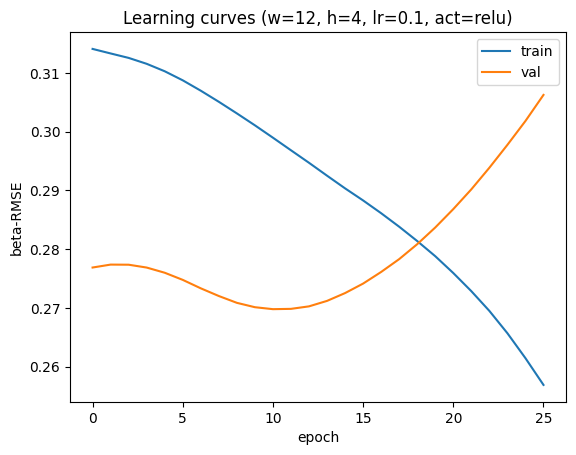

In [14]:
best = tuning_results[0]
hist = best["hist"]
plt.figure()
plt.plot(hist["train_loss"], label="train")
plt.plot(hist["val_loss"], label="val")
plt.xlabel("epoch")
plt.ylabel("beta-RMSE")
plt.title(f"Learning curves (w={best['w']}, h={best['hidden']}, lr={best['lr']}, act={best['activation']})")
plt.legend()
plt.show()


In [15]:
def fit_on_trainval_and_eval_test(monthly, market_set, best):
    w = best["w"]
    panel = make_panel(monthly, market_set, w=w)
    tr, va, te = split_by_date(panel)
    # combine train and val for final fit
    tv = pd.concat([tr, va], axis=0).sort_values(["date","crypto"]).reset_index(drop=True)
    if len(tv)==0 or len(te)==0:
        raise ValueError("Empty Train+Val or Test after splits; check date ranges and data coverage.")

    X_tv, y_tv, a_tv, feat_cols = build_xy(tv)
    X_te, y_te, a_te, _ = build_xy(te)

    # Build model with best hyperparams
    in_dim = X_tv.shape[1]
    act = ACTIVATIONS[best["activation"]]
    model = MLPBeta(in_dim, best["hidden"], act)
    model, hist = train_model(X_tv, y_tv, a_tv, X_te, y_te, a_te,
                              hidden=best["hidden"], lr=best["lr"], activation=act)

    # Inference: get neural beta_hat on TEST rows, and compute RMSE on returns
    model.eval()
    with torch.no_grad():
        beta_hat = model(torch.from_numpy(X_te)).numpy()
    pred_ret = beta_hat * a_te  # predicted crypto return
    rmse = math.sqrt(mean_squared_error(y_te, pred_ret))

    # Build a test dataframe with per-row metadata to compute per-crypto / per-date β
    te_out = te.copy().reset_index(drop=True)
    te_out["beta_hat"] = beta_hat.reshape(-1)
    te_out["pred_ret"] = pred_ret.reshape(-1)
    te_out["error"] = (y_te.reshape(-1) - te_out["pred_ret"].values)

    return te_out, rmse, model, w

best_config = tuning_results[0]
te_out, test_rmse, final_model, BEST_W = fit_on_trainval_and_eval_test(monthly, MARKET_SET, best_config)
print("Test RMSE (returns using beta*asset):", round(test_rmse, 6))
display(te_out.head())


Test RMSE (returns using beta*asset): 0.241711


,date,crypto,target_next,asset_ret_next,c_lag_12,c_lag_11,c_lag_10,c_lag_9,c_lag_8,c_lag_7,c_lag_6,c_lag_5,c_lag_4,c_lag_3,c_lag_2,c_lag_1,a_lag_12,a_lag_11,a_lag_10,a_lag_9,a_lag_8,a_lag_7,a_lag_6,a_lag_5,a_lag_4,a_lag_3,a_lag_2,a_lag_1,beta_hat,pred_ret,error
0,2022-01-31,BTC,0.124270,-0.002963,0.139495,0.371150,0.297348,-0.020353,-0.355420,-0.058080,0.185067,0.134868,-0.068664,0.399220,-0.072619,-0.186972,0.005717,0.007886,0.008789,-0.015278,-0.011818,0.016161,0.001062,0.003876,0.013551,-0.004373,0.018148,-0.007948,-2.101420,0.006227,0.118042
1,2022-02-28,BTC,0.052535,-0.000055,0.371150,0.297348,-0.020353,-0.355420,-0.058080,0.185067,0.134868,-0.068664,0.399220,-0.072619,-0.186972,-0.168978,0.007886,0.008789,-0.015278,-0.011818,0.016161,0.001062,0.003876,0.013551,-0.004373,0.018148,-0.007948,0.002405,-1.566310,0.000086,0.052449
2,2022-03-31,BTC,-0.171900,0.037042,0.297348,-0.020353,-0.355420,-0.058080,0.185067,0.134868,-0.068664,0.399220,-0.072619,-0.186972,-0.168978,0.124270,0.008789,-0.015278,-0.011818,0.016161,0.001062,0.003876,0.013551,-0.004373,0.018148,-0.007948,0.002405,-0.002963,-3.517429,-0.130293,-0.041607
3,2022-04-30,BTC,-0.155456,-0.011923,-0.020353,-0.355420,-0.058080,0.185067,0.134868,-0.068664,0.399220,-0.072619,-0.186972,-0.168978,0.124270,0.052535,-0.015278,-0.011818,0.016161,0.001062,0.003876,0.013551,-0.004373,0.018148,-0.007948,0.002405,-0.002963,-0.000055,-4.476103,0.053368,-0.208824
4,2022-05-31,BTC,-0.376260,0.024586,-0.355420,-0.058080,0.185067,0.134868,-0.068664,0.399220,-0.072619,-0.186972,-0.168978,0.124270,0.052535,-0.171900,-0.011818,0.016161,0.001062,0.003876,0.013551,-0.004373,0.018148,-0.007948,0.002405,-0.002963,-0.000055,0.037042,-2.786235,-0.068504,-0.307757


In [16]:
def descriptives_by_crypto(te_out: pd.DataFrame) -> pd.DataFrame:
    stats = []
    for c, g in te_out.groupby("crypto"):
        x = g["beta_hat"].values
        stats.append({
            "crypto": c,
            "n": len(x),
            "mean": np.mean(x),
            "std": np.std(x, ddof=1) if len(x)>1 else np.nan,
            "skew": skew(x) if len(x)>2 else np.nan,
            "kurtosis": kurtosis(x) if len(x)>3 else np.nan,
            "min": np.min(x),
            "p1": np.percentile(x, 1),
            "p5": np.percentile(x, 5),
            "p25": np.percentile(x, 25),
            "p50": np.percentile(x, 50),
            "p75": np.percentile(x, 75),
            "p95": np.percentile(x, 95),
            "p99": np.percentile(x, 99),
            "max": np.max(x),
        })
    return pd.DataFrame(stats).sort_values("crypto")

desc = descriptives_by_crypto(te_out)
display(desc)


,crypto,n,mean,std,skew,kurtosis,min,p1,p5,p25,p50,p75,p95,p99,max
0,BCH,24,-4.158473,2.446669,-0.401949,-0.742509,-9.285189,-9.046777,-8.235146,-5.927186,-3.727292,-2.040406,-0.902365,-0.851673,-0.851559
1,BTC,24,-3.609592,1.520969,-0.186883,-0.616215,-6.722154,-6.619599,-6.202100,-4.416187,-3.653391,-2.615031,-1.404870,-1.370196,-1.368005
2,ETH,24,-3.506712,1.746396,-0.616170,0.034454,-7.863714,-7.553742,-6.407083,-4.434360,-3.250605,-2.207012,-1.004572,-0.867102,-0.851559
3,LTC,24,-3.480042,1.709459,-0.353690,-0.602705,-7.229112,-7.069603,-6.357512,-4.656602,-3.585517,-2.061397,-1.151551,-1.099431,-1.090770


,year,crypto,mean,std
0,2022,BCH,-2.986851,1.756660
1,2022,BTC,-2.986197,1.357955
2,2022,ETH,-3.072699,1.881412
3,2022,LTC,-2.920131,1.515128
4,2023,BCH,-5.330095,2.536876
5,2023,BTC,-4.232987,1.464600
6,2023,ETH,-3.940725,1.557682
7,2023,LTC,-4.039953,1.769335


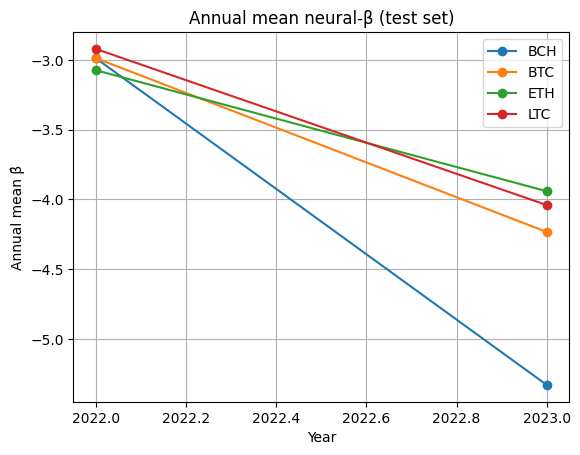

In [17]:
tmp = te_out.copy()
tmp["year"] = pd.to_datetime(tmp["date"]).dt.year
ann = tmp.groupby(["year","crypto"])["beta_hat"].agg(["mean","std"]).reset_index()
display(ann.head(20))

plt.figure()
for c, g in ann.groupby("crypto"):
    plt.plot(g["year"], g["mean"], marker="o", label=c)
plt.xlabel("Year"); plt.ylabel("Annual mean β̂")
plt.title("Annual mean neural-β (test set)")
plt.legend(); plt.grid(True); plt.show()


EW spread (Q4-Q1) mean: 0.029938793259130608
VW spread (Q4-Q1) mean: 0.029938793259130608


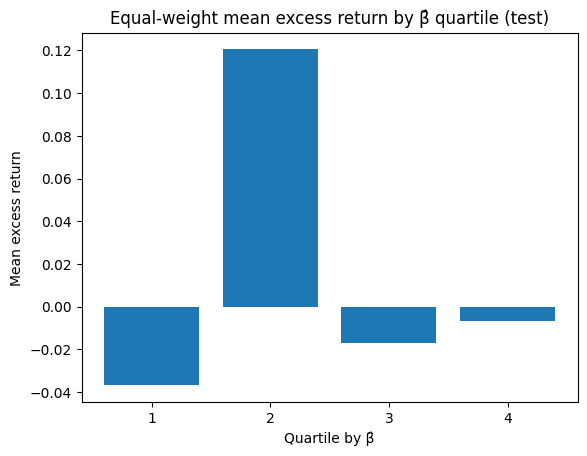

In [18]:
def quartile_sorts(te_out: pd.DataFrame, monthly: pd.DataFrame, market_set: List[str]):
    # Build a test-month panel with each crypto's next-month return (already inside te_out as target_next)
    df = te_out[["date","crypto","beta_hat","target_next","asset_ret_next"]].copy()

    # Equal-weight excess return per quartile
    res = []
    for d, g in df.groupby("date"):
        # rank 4 cryptos by beta_hat
        g = g.sort_values("beta_hat").reset_index(drop=True)
        g["q"] = [1,2,3,4]  # one per quartile (since only 4 cryptos)

        for q, gg in g.groupby("q"):
            ew_excess = (gg["target_next"] - gg["asset_ret_next"]).mean()
            res.append({"date": d, "q": q, "ew_excess": ew_excess, "avg_beta": gg["beta_hat"].mean()})

    res = pd.DataFrame(res).sort_values(["date","q"]).reset_index(drop=True)

    # Value-weight (weights proportional to |mean monthly return| over TRAIN window)
    # Compute crypto |mean ret| on TRAIN to avoid look-ahead
    cryptos = ["BTC","ETH","LTC","BCH"]
    m = monthly[["date"] + cryptos].copy()
    train_mask = (m["date"] >= pd.to_datetime(f"{TRAIN_START}-01")) & \
                 (m["date"] <= pd.to_datetime(f"{TRAIN_END}-28") + pd.offsets.MonthEnd(0))
    m_train = m.loc[train_mask].dropna()
    abs_mean = m_train[cryptos].abs().mean().to_dict()  # { "BTC": val, ... }

    vw_rows = []
    for d, g in df.groupby("date"):
        g = g.sort_values("beta_hat").reset_index(drop=True)
        g["q"] = [1,2,3,4]
        for q, gg in g.groupby("q"):
            weights = gg["crypto"].map(abs_mean)
            weights = weights / weights.sum()
            vw_excess = ((gg["target_next"] - gg["asset_ret_next"]) * weights.values).sum()
            vw_rows.append({"date": d, "q": q, "vw_excess": vw_excess, "avg_beta": gg["beta_hat"].mean()})

    vw = pd.DataFrame(vw_rows).sort_values(["date","q"]).reset_index(drop=True)

    # Q4 - Q1 spreads
    ew_spread = res[res["q"]==4].set_index("date")["ew_excess"] - res[res["q"]==1].set_index("date")["ew_excess"]
    vw_spread = vw[vw["q"]==4].set_index("date")["vw_excess"] - vw[vw["q"]==1].set_index("date")["vw_excess"]

    return res, vw, ew_spread, vw_spread

ew, vw, ew_spread, vw_spread = quartile_sorts(te_out, monthly, MARKET_SET)
print("EW spread (Q4-Q1) mean:", ew_spread.mean())
print("VW spread (Q4-Q1) mean:", vw_spread.mean())

# Plot average per-quartile excess return across test months
plt.figure()
plt.bar([1,2,3,4], ew.groupby("q")["ew_excess"].mean().values)
plt.xticks([1,2,3,4]); plt.title("Equal-weight mean excess return by β̂ quartile (test)")
plt.xlabel("Quartile by β̂"); plt.ylabel("Mean excess return")
plt.show()


In [19]:
FF5_FILE = "F-F_Research_Data_5_Factors_2x3.csv"  # change if needed
ff_path = os.path.join(DATA_DIR, FF5_FILE)

if os.path.exists(ff_path):
    ff = pd.read_csv(ff_path)
    # Try to parse a YYYYMM or YYYY-MM date; adjust as needed for your file
    # If 'Date' is integer like 201501, convert to YYYY-MM end-of-month
    if "Date" in ff.columns:
        ff["Date"] = ff["Date"].astype(str)
        if ff["Date"].str.len().eq(6).all():
            ff["year"] = ff["Date"].str.slice(0,4).astype(int)
            ff["month"] = ff["Date"].str.slice(4,6).astype(int)
            ff["date"] = pd.to_datetime(dict(year=ff["year"], month=ff["month"], day=1)) + pd.offsets.MonthEnd(0)
        else:
            ff["date"] = pd.to_datetime(ff["Date"])
    else:
        # fallback: assume a 'date' column exists
        ff["date"] = pd.to_datetime(ff["date"])

    keep = ["date","SMB","HML","RMW","CMA","RF"]
    # Also include "Mkt-RF" if present
    if "Mkt-RF" in ff.columns:
        keep.append("Mkt-RF")
    ff = ff[keep].dropna().reset_index(drop=True)

    # Merge into our monthly frame
    monthly_ff = monthly.merge(ff, on="date", how="inner")
    print("Merged monthly with FF5; shape:", monthly_ff.shape)

    # Example: re-run the tuning with MARKET_SET + FF factors
    # We’ll modify make_panel to also include factor windows if present:

    def make_panel_with_ff(monthly_df: pd.DataFrame, market_cols: List[str], w: int, use_ff: bool=True) -> pd.DataFrame:
        df = monthly_df.copy()
        # Build equal-weighted asset_ret from market_cols
        if len(market_cols) == 1:
            df["asset_ret"] = df[market_cols[0]]
        else:
            df["asset_ret"] = df[market_cols].mean(axis=1)

        cryptos = ["BTC","ETH","LTC","BCH"]
        factor_cols = [c for c in ["SMB","HML","RMW","CMA","Mkt-RF","RF"] if c in df.columns] if use_ff else []

        rows = []
        for c in cryptos:
            cdf = df[["date", c, "asset_ret"] + factor_cols].copy()
            for i in range(w, len(cdf)-1):
                window = cdf.iloc[i-w:i]
                d_t = cdf.iloc[i]["date"]
                target_next = cdf.iloc[i+1][c]
                asset_next  = cdf.iloc[i+1]["asset_ret"]

                feats = {}
                # crypto lags
                for k, r in enumerate(window[c].values):
                    feats[f"c_lag_{w-k}"] = r
                # market lags
                for k, r in enumerate(window["asset_ret"].values):
                    feats[f"a_lag_{w-k}"] = r
                # FF factor lags
                for fcol in factor_cols:
                    arr = window[fcol].values.astype(float)
                    for k, r in enumerate(arr):
                        feats[f"{fcol}_lag_{w-k}"] = r

                rows.append({
                    "date": d_t,
                    "crypto": c,
                    "target_next": target_next,
                    "asset_ret_next": asset_next,
                    **feats
                })

        out = pd.DataFrame(rows).dropna().reset_index(drop=True)
        return out

    # Example small run (reuse your chosen best market_set and lookback):
    panel_ff = make_panel_with_ff(monthly_ff, MARKET_SET, w=BEST_W, use_ff=True)
    tr, va, te = split_by_date(panel_ff)
    X_tr, y_tr, a_tr, _ = build_xy(tr); X_va, y_va, a_va, _ = build_xy(va)
    model_ff, hist_ff = train_model(X_tr, y_tr, a_tr, X_va, y_va, a_va,
                                    hidden=best_config["hidden"], lr=best_config["lr"],
                                    activation=ACTIVATIONS[best_config["activation"]])
    # Evaluate on test
    X_te, y_te, a_te, _ = build_xy(te)
    with torch.no_grad():
        bh = model_ff(torch.from_numpy(X_te)).numpy()
    pred = bh * a_te
    rmse_ff = math.sqrt(mean_squared_error(y_te, pred))
    print("Test RMSE with FF factors:", rmse_ff)
else:
    print("FF5 file not found; skip Step 7/8. Put the CSV in DATA_DIR and re-run this cell.")


FF5 file not found; skip Step 7/8. Put the CSV in DATA_DIR and re-run this cell.


In [20]:
print("Crypto ret mean (test):")
print(te_out.groupby("crypto")["target_next"].mean())

print("\nFIAT ret mean (test):", te_out["asset_ret_next"].mean())
print("FIAT ret std (test):", te_out["asset_ret_next"].std())


Crypto ret mean (test):
crypto
BCH    0.042627
BTC    0.017863
ETH    0.013117
LTC   -0.005742
Name: target_next, dtype: float64

FIAT ret mean (test): 0.0020101835586683096
FIAT ret std (test): 0.018837527656076398


In [21]:
import statsmodels.api as sm

roll = []
for c in ["BTC","ETH","LTC","BCH"]:
    sub = monthly[["date",c,"FIAT"]].dropna().copy()
    for i in range(36, len(sub)):
        w = sub.iloc[i-36:i]
        X = sm.add_constant(w["FIAT"])
        y = w[c]
        beta = sm.OLS(y,X).fit().params["FIAT"]
        roll.append({"date": sub.iloc[i]["date"], "crypto": c, "ols_beta": beta})

ols_df = pd.DataFrame(roll)
print(ols_df.groupby("crypto")["ols_beta"].mean())


crypto
BCH   -4.928630
BTC   -3.530669
ETH   -4.511549
LTC   -5.260660
Name: ols_beta, dtype: float64


In [25]:
import os, pandas as pd, numpy as np
from io import StringIO

# 1) Point to your uploaded monthly CSV (change the filename below if needed)
FF5_FILE = "F-F_Research_Data_5_Factors_2x3.csv"   # <- set to your exact uploaded monthly CSV name
ff_path = os.path.join(DATA_DIR, FF5_FILE)
if not os.path.exists(ff_path):
    raise FileNotFoundError(f"FF5 file not found at {ff_path}")

# 2) Read raw text and locate the monthly data block (skip prose header, stop before Annual section)
with open(ff_path, "r", encoding="latin-1") as f:
    raw_lines = f.read().splitlines()

def _looks_yyyymm(token: str) -> bool:
    t = token.strip()
    return t.isdigit() and len(t) == 6 and t[:4].isdigit() and 1 <= int(t[4:6]) <= 12

start_idx = None
for i, line in enumerate(raw_lines):
    # first column before comma
    token = line.split(",")[0].strip()
    if _looks_yyyymm(token):
        start_idx = i
        break
if start_idx is None:
    raise RuntimeError("Could not find the start of the monthly YYYYMM block in the FF5 CSV.")

end_idx = None
for i in range(start_idx, len(raw_lines)):
    if raw_lines[i].strip().lower().startswith("annual"):
        end_idx = i
        break
if end_idx is None:
    end_idx = len(raw_lines)

block = "\n".join(raw_lines[start_idx:end_idx])

# 3) Load the block without assuming exact header names; assign canonical names
tmp = pd.read_csv(StringIO(block), header=None)
# Expect 7 columns: YYYYMM, Mkt-RF, SMB, HML, RMW, CMA, RF
if tmp.shape[1] < 7:
    # sometimes there is a trailing comma; try again letting pandas infer
    tmp = pd.read_csv(StringIO(block))
# After inference, still normalize to 7 columns
if tmp.shape[1] >= 7:
    tmp = tmp.iloc[:, :7]
else:
    raise RuntimeError(f"Unexpected FF5 monthly format with {tmp.shape[1]} columns (need 7).")

tmp.columns = ["YYYYMM","Mkt_RF","SMB","HML","RMW","CMA","RF"]

# 4) Clean types: YYYYMM → datetime month-end; returns are % → decimals
tmp["YYYYMM"] = tmp["YYYYMM"].astype(str).str.strip()
# keep only real YYYYMM rows
tmp = tmp[tmp["YYYYMM"].str.match(r"^\d{6}$", na=False)].copy()

tmp["date"] = pd.to_datetime(tmp["YYYYMM"], format="%Y%m", errors="coerce") + pd.offsets.MonthEnd(0)
for col in ["Mkt_RF","SMB","HML","RMW","CMA","RF"]:
    tmp[col] = pd.to_numeric(tmp[col], errors="coerce") / 100.0

ff5 = tmp.dropna(subset=["date"]).loc[:, ["date","Mkt_RF","SMB","HML","RMW","CMA","RF"]].reset_index(drop=True)

print("FF5 parsed. Range:", ff5["date"].min().date(), "→", ff5["date"].max().date(), "rows:", len(ff5))
display(ff5.head())


FF5 parsed. Range: 1963-07-31 → 2025-08-31 rows: 746


,date,Mkt_RF,SMB,HML,RMW,CMA,RF
0,1963-07-31,-0.0039,-0.0048,-0.0081,0.0064,-0.0115,0.0027
1,1963-08-31,0.0508,-0.0080,0.0170,0.0040,-0.0038,0.0025
2,1963-09-30,-0.0157,-0.0043,0.0000,-0.0078,0.0015,0.0027
3,1963-10-31,0.0254,-0.0134,-0.0004,0.0279,-0.0225,0.0029
4,1963-11-30,-0.0086,-0.0085,0.0173,-0.0043,0.0227,0.0027


In [26]:
# 1) Merge FF5 into your existing 'monthly'
monthly_ff = monthly.merge(ff5, on="date", how="left")

# 2) Build the panel as before, but now include FF lags in the feature window
def make_panel_with_ff(monthly_df, w=12, market_col="FIAT"):
    """
    Builds panel with:
      target_next = crypto return at t+1
      asset_ret_next = market_col return at t+1
      c_lag_k = crypto return at t-k
      a_lag_k = market_col return at t-k
      ff_*_lag_k = FF factor returns at t-k (Mkt_RF, SMB, HML, RMW, CMA)
    """
    cryptos = ["BTC","ETH","LTC","BCH"]
    facs = ["Mkt_RF","SMB","HML","RMW","CMA"]  # keep RF for excess calc if you switch to equities later

    rows = []
    for c in cryptos:
        df = monthly_df[["date", c, market_col] + facs].dropna().sort_values("date").reset_index(drop=True)

        for i in range(w, len(df)-1):
            t = i   # last lag index (t)
            nxt = i+1  # predict t+1

            rec = {
                "date":          df.loc[nxt, "date"],
                "crypto":        c,
                "target_next":   float(df.loc[nxt, c]),
                "asset_ret_next":float(df.loc[nxt, market_col]),
            }

            # crypto lags
            for k in range(1, w+1):
                rec[f"c_lag_{k}"] = float(df.loc[t-(k-1), c])

            # market lags
            for k in range(1, w+1):
                rec[f"a_lag_{k}"] = float(df.loc[t-(k-1), market_col])

            # FF factor lags
            for fac in facs:
                for k in range(1, w+1):
                    rec[f"{fac.lower()}_lag_{k}"] = float(df.loc[t-(k-1), fac])

            rows.append(rec)

    panel = pd.DataFrame(rows)
    return panel.sort_values(["date","crypto"]).reset_index(drop=True)

# Rebuild panel with FF factors at your chosen w (12 worked for you)
w_best = 12
market = "FIAT"  # keep as FIAT for consistency with your previous results
panel_ff = make_panel_with_ff(monthly_ff, w=w_best, market_col=market)

print(f"Panel with FF factors shape (w={w_best}):", panel_ff.shape)
display(panel_ff.head())


Panel with FF factors shape (w=12): (316, 88)


,date,crypto,target_next,asset_ret_next,c_lag_1,c_lag_2,c_lag_3,c_lag_4,c_lag_5,c_lag_6,c_lag_7,c_lag_8,c_lag_9,c_lag_10,c_lag_11,c_lag_12,a_lag_1,a_lag_2,a_lag_3,a_lag_4,a_lag_5,a_lag_6,a_lag_7,a_lag_8,a_lag_9,a_lag_10,a_lag_11,a_lag_12,mkt_rf_lag_1,mkt_rf_lag_2,mkt_rf_lag_3,mkt_rf_lag_4,mkt_rf_lag_5,mkt_rf_lag_6,mkt_rf_lag_7,mkt_rf_lag_8,mkt_rf_lag_9,mkt_rf_lag_10,mkt_rf_lag_11,mkt_rf_lag_12,smb_lag_1,smb_lag_2,smb_lag_3,smb_lag_4,smb_lag_5,smb_lag_6,smb_lag_7,smb_lag_8,smb_lag_9,smb_lag_10,smb_lag_11,smb_lag_12,hml_lag_1,hml_lag_2,hml_lag_3,hml_lag_4,hml_lag_5,hml_lag_6,hml_lag_7,hml_lag_8,hml_lag_9,hml_lag_10,hml_lag_11,hml_lag_12,rmw_lag_1,rmw_lag_2,rmw_lag_3,rmw_lag_4,rmw_lag_5,rmw_lag_6,rmw_lag_7,rmw_lag_8,rmw_lag_9,rmw_lag_10,rmw_lag_11,rmw_lag_12,cma_lag_1,cma_lag_2,cma_lag_3,cma_lag_4,cma_lag_5,cma_lag_6,cma_lag_7,cma_lag_8,cma_lag_9,cma_lag_10,cma_lag_11,cma_lag_12
0,2019-02-28,BCH,0.145994,0.005720,-0.234963,-0.133517,-0.596872,-0.202163,-0.023591,-0.301064,0.037599,-0.248090,-0.263230,0.977262,-0.428893,-0.187949,-0.017471,-0.007262,-0.000984,0.023897,-0.004094,0.013708,-0.004667,0.011343,0.024259,0.017281,-0.008412,0.015178,0.0836,-0.0955,0.0171,-0.0764,0.0006,0.0346,0.0320,0.0049,0.0263,0.0029,-0.0235,-0.0364,0.0291,-0.0281,-0.0081,-0.0438,-0.0249,0.0065,-0.0193,0.0077,0.0471,0.0089,0.0361,0.0034,-0.0039,-0.0192,0.0036,0.0338,-0.0162,-0.0391,0.0049,-0.0233,-0.0314,0.0053,-0.0021,-0.0110,-0.0073,-0.0003,-0.0061,0.0103,0.0065,-0.0029,0.0153,0.0083,-0.0198,-0.0242,-0.0041,0.0053,-0.0165,0.0024,0.0040,0.036,0.0136,-0.0257,0.0031,0.0020,-0.0149,0.0124,0.0008,-0.0236
1,2019-02-28,BTC,0.111576,0.005720,-0.075940,-0.071464,-0.369307,-0.045544,-0.058448,-0.092175,0.210566,-0.147202,-0.190270,0.334173,-0.327805,0.020523,-0.017471,-0.007262,-0.000984,0.023897,-0.004094,0.013708,-0.004667,0.011343,0.024259,0.017281,-0.008412,0.015178,0.0836,-0.0955,0.0171,-0.0764,0.0006,0.0346,0.0320,0.0049,0.0263,0.0029,-0.0235,-0.0364,0.0291,-0.0281,-0.0081,-0.0438,-0.0249,0.0065,-0.0193,0.0077,0.0471,0.0089,0.0361,0.0034,-0.0039,-0.0192,0.0036,0.0338,-0.0162,-0.0391,0.0049,-0.0233,-0.0314,0.0053,-0.0021,-0.0110,-0.0073,-0.0003,-0.0061,0.0103,0.0065,-0.0029,0.0153,0.0083,-0.0198,-0.0242,-0.0041,0.0053,-0.0165,0.0024,0.0040,0.036,0.0136,-0.0257,0.0031,0.0020,-0.0149,0.0124,0.0008,-0.0236
2,2019-02-28,ETH,0.271198,0.005720,-0.189535,0.169100,-0.433105,-0.152064,-0.176172,-0.347889,-0.046196,-0.214538,-0.138412,0.697699,-0.535830,-0.230785,-0.017471,-0.007262,-0.000984,0.023897,-0.004094,0.013708,-0.004667,0.011343,0.024259,0.017281,-0.008412,0.015178,0.0836,-0.0955,0.0171,-0.0764,0.0006,0.0346,0.0320,0.0049,0.0263,0.0029,-0.0235,-0.0364,0.0291,-0.0281,-0.0081,-0.0438,-0.0249,0.0065,-0.0193,0.0077,0.0471,0.0089,0.0361,0.0034,-0.0039,-0.0192,0.0036,0.0338,-0.0162,-0.0391,0.0049,-0.0233,-0.0314,0.0053,-0.0021,-0.0110,-0.0073,-0.0003,-0.0061,0.0103,0.0065,-0.0029,0.0153,0.0083,-0.0198,-0.0242,-0.0041,0.0053,-0.0165,0.0024,0.0040,0.036,0.0136,-0.0257,0.0031,0.0020,-0.0149,0.0124,0.0008,-0.0236
3,2019-02-28,LTC,0.454545,0.005720,0.049026,-0.059084,-0.360218,-0.189681,-0.017383,-0.212348,-0.026293,-0.315563,-0.202049,0.275628,-0.424698,0.248425,-0.017471,-0.007262,-0.000984,0.023897,-0.004094,0.013708,-0.004667,0.011343,0.024259,0.017281,-0.008412,0.015178,0.0836,-0.0955,0.0171,-0.0764,0.0006,0.0346,0.0320,0.0049,0.0263,0.0029,-0.0235,-0.0364,0.0291,-0.0281,-0.0081,-0.0438,-0.0249,0.0065,-0.0193,0.0077,0.0471,0.0089,0.0361,0.0034,-0.0039,-0.0192,0.0036,0.0338,-0.0162,-0.0391,0.0049,-0.0233,-0.0314,0.0053,-0.0021,-0.0110,-0.0073,-0.0003,-0.0061,0.0103,0.0065,-0.0029,0.0153,0.0083,-0.0198,-0.0242,-0.0041,0.0053,-0.0165,0.0024,0.0040,0.036,0.0136,-0.0257,0.0031,0.0020,-0.0149,0.0124,0.0008,-0.0236
4,2019-03-31,BCH,0.302843,0.008225,0.145994,-0.234963,-0.133517,-0.596872,-0.202163,-0.023591,-0.301064,0.037599,-0.248090,-0.263230,0.977262,-0.428893,0.005720,-0.017471,-0.007262,-0.000984,0.023897,-0.004094,0.013708,-0.004667,0.011343,0.024259,0.017281,-

In [27]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

def split_by_dates(df, train=(TRAIN_START, TRAIN_END), val=(VAL_START, VAL_END), test=(TEST_START, TEST_END)):
    d = df.copy()
    d["date"] = pd.to_datetime(d["date"])
    tr = d[(d["date"] >= pd.to_datetime(train[0])) & (d["date"] <= pd.to_datetime(train[1]) + pd.offsets.MonthEnd(0))]
    va = d[(d["date"] >= pd.to_datetime(val[0]))   & (d["date"] <= pd.to_datetime(val[1])   + pd.offsets.MonthEnd(0))]
    te = d[(d["date"] >= pd.to_datetime(test[0]))  & (d["date"] <= pd.to_datetime(test[1])  + pd.offsets.MonthEnd(0))]
    return tr.reset_index(drop=True), va.reset_index(drop=True), te.reset_index(drop=True)

# Build X,y,a for the new panel (FF features included automatically)
def build_xy_ff(df):
    all_cols = df.columns.tolist()
    feat_cols = [c for c in all_cols if c.startswith("c_lag_") or c.startswith("a_lag_") or
                 c.startswith("mkt_rf_lag_") or c.startswith("smb_lag_") or
                 c.startswith("hml_lag_") or c.startswith("rmw_lag_") or c.startswith("cma_lag_")]
    X = df[feat_cols].to_numpy(dtype=np.float32)
    y = df["target_next"].to_numpy(dtype=np.float32).reshape(-1,1)
    a = df["asset_ret_next"].to_numpy(dtype=np.float32).reshape(-1,1)
    return X, y, a, feat_cols

# Same beta-loss net you used before
class BetaNet(nn.Module):
    def __init__(self, d_in, hidden, activation):
        super().__init__()
        self.fc1 = nn.Linear(d_in, hidden)
        self.act = activation
        self.out = nn.Linear(hidden, 1)
    def forward(self, x):
        h = self.act(self.fc1(x))
        return self.out(h)  # beta_hat

def beta_rmse_loss(beta_hat, y_true, a_next):
    pred = beta_hat * a_next
    return torch.sqrt(torch.mean((pred - y_true)**2))

def fit_eval(panel, w, hidden, lr, activation, epochs=EPOCHS, batch=BATCH_SIZE, verbose=False):
    tr, va, te = split_by_dates(panel)
    Xtr, ytr, atr, feat = build_xy_ff(tr)
    Xva, yva, ava, _   = build_xy_ff(va)
    Xte, yte, ate, _   = build_xy_ff(te)

    act = ACTIVATIONS[activation]
    model = BetaNet(d_in=Xtr.shape[1], hidden=hidden, activation=act)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Dataloaders
    def dl(X,y,a):
        return DataLoader(TensorDataset(torch.tensor(X), torch.tensor(y), torch.tensor(a)),
                          batch_size=batch, shuffle=True)
    tr_dl, va_dl = dl(Xtr,ytr,atr), dl(Xva,yva,ava)

    best = (1e9, None)
    patience = PATIENCE
    for ep in range(epochs):
        model.train()
        for xb, yb, ab in tr_dl:
            opt.zero_grad()
            loss = beta_rmse_loss(model(xb), yb, ab)
            loss.backward()
            opt.step()
        # val
        model.eval()
        with torch.no_grad():
            vb = beta_rmse_loss(model(torch.tensor(Xva)), torch.tensor(yva), torch.tensor(ava)).item()
        if vb < best[0]:
            best = (vb, model.state_dict())
            patience = PATIENCE
        else:
            patience -= 1
            if patience == 0:
                break

    model.load_state_dict(best[1])
    model.eval()
    with torch.no_grad():
        test_rmse = beta_rmse_loss(model(torch.tensor(Xte)), torch.tensor(yte), torch.tensor(ate)).item()

    return {"val_rmse": best[0], "test_rmse": test_rmse, "w": w, "hidden": hidden, "lr": lr, "activation": activation}

# ---- Grid (reuse your tried values) ----
results_ff = []
for hidden in [4,8,16]:
    for lr in [1e-3, 1e-2, 1e-1]:
        for act in ["linear","sigmoid","tanh","relu"]:
            r = fit_eval(panel_ff, w_best, hidden, lr, act)
            results_ff.append(r)
            print(r)

# Pick best-by-val
best_ff = sorted(results_ff, key=lambda d: d["val_rmse"])[0]
print("\nBest with FF factors:", best_ff)
print("Compare to your previous best (no FF): Test RMSE ~ 0.241711")

# (Optional) compute betas & plots again with the best FF model like you already did.


{'val_rmse': 0.2964608371257782, 'test_rmse': 0.2575503885746002, 'w': 12, 'hidden': 4, 'lr': 0.001, 'activation': 'linear'}
{'val_rmse': 0.29384881258010864, 'test_rmse': 0.25499269366264343, 'w': 12, 'hidden': 4, 'lr': 0.001, 'activation': 'sigmoid'}
{'val_rmse': 0.2974458336830139, 'test_rmse': 0.2582884430885315, 'w': 12, 'hidden': 4, 'lr': 0.001, 'activation': 'tanh'}
{'val_rmse': 0.2945452928543091, 'test_rmse': 0.2554730176925659, 'w': 12, 'hidden': 4, 'lr': 0.001, 'activation': 'relu'}
{'val_rmse': 0.2943294644355774, 'test_rmse': 0.25706925988197327, 'w': 12, 'hidden': 4, 'lr': 0.01, 'activation': 'linear'}
{'val_rmse': 0.2966468930244446, 'test_rmse': 0.25979238748550415, 'w': 12, 'hidden': 4, 'lr': 0.01, 'activation': 'sigmoid'}
{'val_rmse': 0.29695403575897217, 'test_rmse': 0.26008060574531555, 'w': 12, 'hidden': 4, 'lr': 0.01, 'activation': 'tanh'}
{'val_rmse': 0.29576197266578674, 'test_rmse': 0.2568678855895996, 'w': 12, 'hidden': 4, 'lr': 0.01, 'activation': 'relu'}
{'v